# PM2.5 forecasting

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pm25_hyperparameters import *

train=pd.read_csv("BeijingPM_train.csv").drop("date",axis=1)
#test=df[df.shape[0]-24:]
#train=df[:df.shape[0]-24]
test=pd.read_csv("BeijingPM_test.csv").drop("date",axis=1)

train.head()

,year,month,day,hour,season,PM,DEWP,HUMI,PRES,TEMP,...,precipitation_max,Iws_max,PM_max,TEMP_min,DEWP_min,HUMI_min,PRES_min,precipitation_min,Iws_min,PM_min
0,2010,1,3,0,4,63.0,-7.0,92.0,1027.0,-6.0,...,0.4,58.56,181.0,-14.0,-21.0,25.0,1014.0,0.0,0.89,63.0
1,2010,1,3,1,4,65.0,-8.0,85.0,1026.0,-6.0,...,0.5,61.69,181.0,-14.0,-21.0,25.0,1014.0,0.0,0.89,63.0
2,2010,1,3,2,4,55.0,-8.0,92.0,1026.0,-7.0,...,0.5,65.71,181.0,-14.0,-21.0,25.0,1014.0,0.0,0.89,55.0
3,2010,1,3,3,4,65.0,-8.0,92.0,1025.0,-7.0,...,0.7,68.84,181.0,-12.0,-20.0,25.0,1014.0,0.0,0.89,55.0
4,2010,1,3,4,4,83.0,-8.0,92.0,1024.0,-7.0,...,1.2,72.86,181.0,-10.0,-20.0,25.0,1014.0,0.0,0.89,55.0


In [3]:
test.head()

,year,month,day,hour,season,PM,DEWP,HUMI,PRES,TEMP,...,precipitation_max,Iws_max,PM_max,TEMP_min,DEWP_min,HUMI_min,PRES_min,precipitation_min,Iws_min,PM_min
0,2015,10,1,0,3,38.0,14.0,93.0,1011.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,10,1,1,3,34.0,14.0,93.0,1010.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,10,1,2,3,2.0,12.0,82.0,1010.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,10,1,3,3,1.0,7.0,58.0,1010.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,10,1,4,3,1.4,6.0,54.0,1010.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Training set for meteorological prediction model

In [4]:
x_met=["year","month","day","hour","season"]
y_met=list(set(prim_fea)-set(["PM"]))

# Column names for lagged features
for col in y_met:
    for t in range(1,lag_hours+1):
        x_met.append("%s_lag%d" % (col,t))
    for r in ["mean","max","min"]:
        x_met.append("%s_%s" % (col,r))

met_xtrain=train[x_met]
met_ytrain=train[y_met]

met_ytest=test[y_met]

## Prepare the testing set

In [12]:
def fill_fea(pos,cols):
    for col in cols:
        lagtmp=[]
        for t in range(1,lag_hours+1):
            if t<=pos:
                x=test.loc[pos-t,col]
            else:
                x=train.loc[train.shape[0]+pos-t,col]
            test.loc[pos,"%s_lag%d" % (col,t)]=x
            lagtmp.append(x)
        test.loc[pos,"%s_mean" % col]=np.mean(lagtmp)
        test.loc[pos,"%s_min" % col]=np.min(lagtmp)
        test.loc[pos,"%s_max" % col]=np.max(lagtmp)

## Predict meteorological parameters

In this section, we predict meteorological parameters for the testing set using primitive datetime features

In [6]:
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV

met_model=MultiOutputRegressor(LGBMRegressor(random_state=101,objective="rmse",eval_metric="rmse"),n_jobs=4)

# Setup cross validation
#lgb_grid={
#    "estimator__objective":["l1","l2","l2_root"],
#    "estimator__max_depth":[15, 20, 25, 30, 35],
#    "estimator__num_leaves":[64,128,256],
#}

#met_model=RandomizedSearchCV(MultiOutputRegressor(LGBMRegressor(),n_jobs=4),lgb_grid,cv=10,n_iter=10,n_jobs=4,random_state=42,verbose=2)
met_model.fit(met_xtrain,met_ytrain)

MultiOutputRegressor(estimator=LGBMRegressor(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             eval_metric='rmse',
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, objective='rmse',
                                             random_state=101, reg_alpha=0.0,
                                             reg_lambda=0.0, silent=True,
                                             subsample=1.0,
                        

In [13]:
for k in tqdm(range(24)):
    fill_fea(k,y_met)
    test.loc[k,y_met]=pd.DataFrame(met_model.predict(test.loc[[k],x_met]),columns=y_met).loc[0]

100%|██████████| 24/24 [00:05<00:00,  4.01it/s]


In [14]:
mae=abs(test.loc[range(24),y_met]-met_ytest.loc[range(24)]).mean()
mae.index=["MAE of %s" % c for c in mae.index]
mae

MAE of TEMP              2.753388
MAE of PRES              2.076904
MAE of DEWP             10.000572
MAE of precipitation     0.578834
MAE of Iws              58.612340
MAE of HUMI             44.192185
dtype: float64

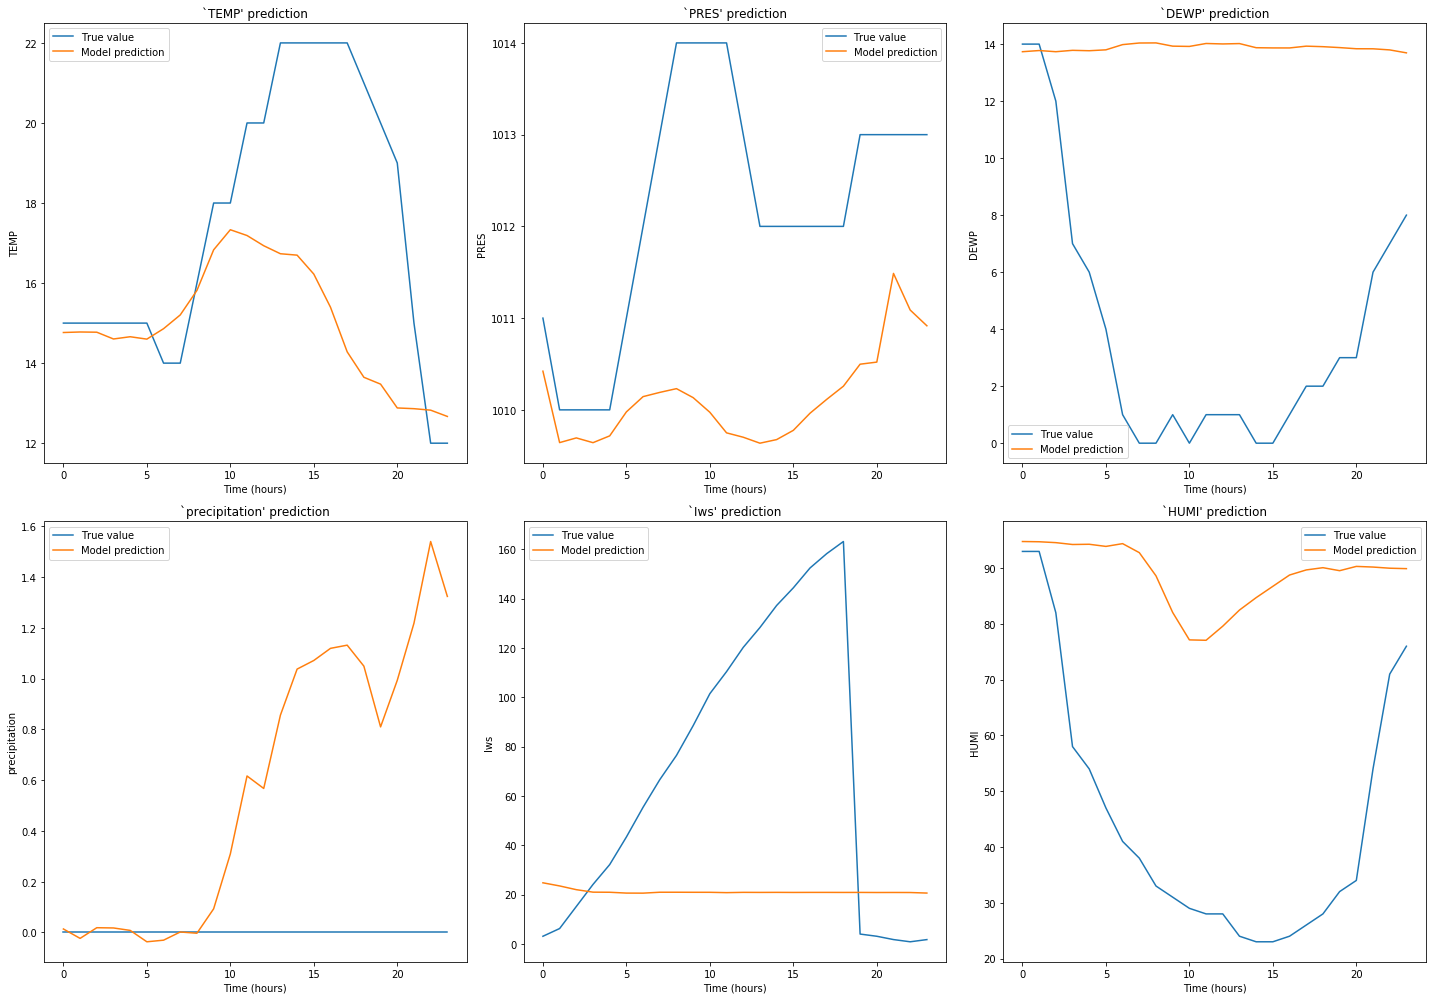

In [15]:
f=plt.figure(figsize=(20,14))
f.set_tight_layout(True)

for i,c in enumerate(y_met):
    ax=plt.subplot(2,3,i+1)
    ax.set_title("`%s' prediction" % c)
    ax.set_xlabel("Time (hours)")
    ax.set_ylabel("%s" % c)
    ax.plot(range(24),met_ytest.loc[range(24),c],label="True value")
    ax.plot(range(24),test.loc[range(24),c],label="Model prediction")
    ax.legend()

plt.savefig("graphs/met_prediction.png")

In [16]:
test.head()

,year,month,day,hour,season,PM,DEWP,HUMI,PRES,TEMP,...,precipitation_max,Iws_max,PM_max,TEMP_min,DEWP_min,HUMI_min,PRES_min,precipitation_min,Iws_min,PM_min
0,2015,10,1,0,3,38.0,13.733451,94.777976,1010.421693,14.765124,...,3.4,31.29,NaN,13.0,12.0,59.0,1011.000000,0.000000,0.89,NaN
1,2015,10,1,1,3,34.0,13.774288,94.734949,1009.643056,14.778018,...,3.4,31.29,NaN,13.0,12.0,59.0,1010.421693,0.000000,0.89,NaN
2,2015,10,1,2,3,2.0,13.733361,94.575310,1009.694137,14.772611,...,3.4,31.29,NaN,13.0,12.0,59.0,1009.643056,-0.023188,0.89,NaN
3,2015,10,1,3,3,1.0,13.781761,94.243013,1009.642366,14.603348,...,3.4,31.29,NaN,13.0,12.0,59.0,1009.643056,-0.023188,0.89,NaN
4,2015,10,1,4,3,1.4,13.767828,94.284369,1009.716408,14.659407,...,3.4,31.29,NaN,13.0,12.0,59.0,1009.642366,-0.023188,0.89,NaN


## PM2.5 Prediction

In [37]:
pm_xtrain=train.drop("PM",axis=1)
x_pm=pm_xtrain.columns
pm_ytrain=train["PM"]

lgb_grid={
    "objective":["l1","l2","l2_root"],
    "max_depth":[15, 20, 25, 30, 35],
    "num_leaves":[64,128,256],
}

pm_model=RandomizedSearchCV(LGBMRegressor(random_state=101),n_jobs=4,lgb_grid,verbose=2)
pm_model.fit(pm_xtrain,pm_ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] objective=l2_root, num_leaves=64, max_depth=25 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... objective=l2_root, num_leaves=64, max_depth=25, total=   3.6s
[CV] objective=l2_root, num_leaves=64, max_depth=25 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] ... objective=l2_root, num_leaves=64, max_depth=25, total=   3.7s
[CV] objective=l2_root, num_leaves=64, max_depth=25 ..................
[CV] ... objective=l2_root, num_leaves=64, max_depth=25, total=   3.5s
[CV] objective=l2_root, num_leaves=64, max_depth=25 ..................
[CV] ... objective=l2_root, num_leaves=64, max_depth=25, total=   3.6s
[CV] objective=l2_root, num_leaves=64, max_depth=25 ..................
[CV] ... objective=l2_root, num_leaves=64, max_depth=25, total=   3.6s
[CV] objective=l1, num_leaves=128, max_depth=25 ......................
[CV] ....... objective=l1, num_leaves=128, max_depth=25, total=   5.9s
[CV] objective=l1, num_leaves=128, max_depth=25 ......................
[CV] ....... objective=l1, num_leaves=128, max_depth=25, total=   5.9s
[CV] objective=l1, num_leaves=128, max_depth=25 ......................
[CV] ....... objective=l1, num_leaves=128, max_depth=25, total=   5.9s
[CV] objective=l1, num_leaves=128, max_depth=25 ......................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  5.1min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=101,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silent=True, subsample=1.0,
                                           subsample_for_bin=200000,
                                           sub

In [43]:
pm_model.best_params_

{'objective': 'l2', 'num_leaves': 64, 'max_depth': 30}

In [45]:
pm_predict=[]
for k in tqdm(range(24),desc="Predicting PM2.5"):
    fill_fea(k,["PM"])
    pm_predict.append(pm_model.predict(test.loc[[k],x_pm]))

Predicting PM2.5: 100%|██████████| 24/24 [00:02<00:00, 11.50it/s]


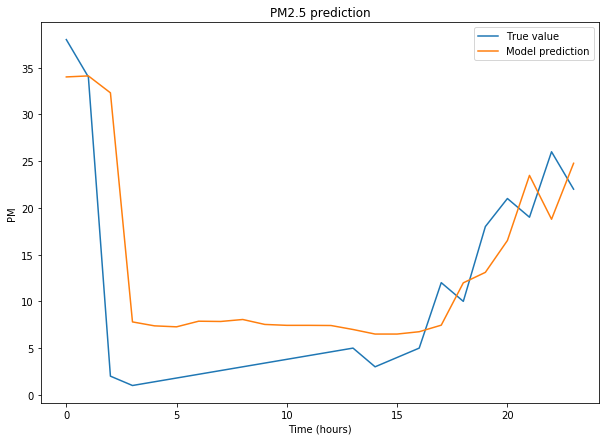

In [46]:
fg=plt.figure(figsize=(10,7))
ax=fg.gca()

ax.set_title("PM2.5 prediction")
ax.plot(range(24),test.loc[range(24),"PM"],label="True value")
ax.plot(range(24),pm_predict,label="Model prediction")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("PM")
ax.legend()

plt.savefig("graphs/pm_prediction.png")

In [40]:
np.abs(np.array(pm_predict)-np.array(test.loc[range(24),"PM"])).mean()

11.222230633774721